# Isolation Forest
Isolation Forest is an unsupervised machine learning algorithm for anomaly detection. As the name implies, Isolation Forest is an ensemble method (similar to random forest). In other words, it use the average of the predictions by several decision trees when assigning the final anomaly score to a given data point. Unlike other anomaly detection algorithms, which first define what's "normal" and then report anything else as anomalous, Isolation Forest attempts to isolate anomalous data points from the get go.

In [110]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import pandas as pd

In [111]:
breast_cancer = load_breast_cancer()
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df = df.assign(benign = breast_cancer.target)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,benign
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [112]:
df.benign.value_counts()

benign
1    357
0    212
Name: count, dtype: int64

For our use case, we will assume that a malignant label is anomalous. The dataset contains a relatively high number of malignant tumors. Thus, we make use of downsampling.

In [113]:
majority_class = df[df.benign == 1] # or df.loc[df.benign == 1] or df.query('benign == 1')
minority_class = df[df.benign == 0]

minority_downsample = resample(minority_class, replace=False, n_samples=30, random_state=42)
df_downsample = pd.concat([majority_class, minority_downsample])
df_downsample.benign.value_counts()

benign
1    357
0     30
Name: count, dtype: int64

In [114]:
X = df_downsample.drop('benign', axis=1)
y = df_downsample.benign


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = IsolationForest(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [116]:
y_pred

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1])

In [117]:
y_test

513    1
298    1
187    1
452    1
376    1
      ..
527    1
518    1
66     1
149    1
322    1
Name: benign, Length: 97, dtype: int32

In [118]:
y_pred[y_pred == -1] = 0

In [119]:
confusion_matrix(y_test, y_pred)

array([[ 7,  2],
       [ 3, 85]], dtype=int64)

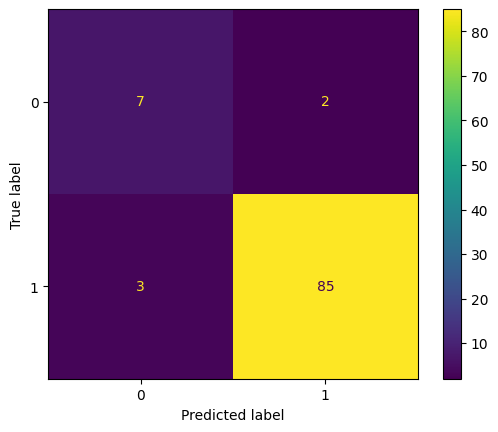

In [120]:
# ConfusionMatrixPlot 
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [121]:
recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])

print(f'Recall: {recall:.2%}')
print(f'Precision: {precision:.2%}')

Recall: 96.59%
Precision: 97.70%


In [122]:
# trying GridSearchCV and BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    'contamination': [0.05, 0.1, 0.15, 0.2, 0.25,'auto']
}

model = IsolationForest(random_state=42)
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_params_


{'contamination': 0.05}

In [123]:
grid.best_score_

0.9

In [124]:
y_pred = grid.predict(X_test)
y_pred[y_pred == -1] = 0
cm = confusion_matrix(y_test, y_pred)



In [125]:
recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])

print(f'Recall: {recall:.2%}')
print(f'Precision: {precision:.2%}')

Recall: 97.73%
Precision: 94.51%
